## Experiment to Visualize LFP Decision Boundaries on Toy Data

### Imports

In [1]:
import copy
import os
import random

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

from experiment_utils.data import dataloaders, datasets, transforms
from experiment_utils.evaluation import evaluate
from experiment_utils.utils.utils import register_backward_normhooks
from lfprop.propagation import propagator_lxt as propagator
from lfprop.rewards import rewards

### Experiment Variables

In [2]:
dataset_name = "blobs"
n_channels = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8
lrs = [0.5]
momentum = 0.0
reward_name = "binarysigmoidlossreward"
loss_name = "bce-loss"
norm_backward = False
epochs = 1
n_datasets = 1
weight_initializations = [
    (0.0, 4.0),
    (4.0, 0.0),
    (2.0, 4.0),
    (4.0, 2.0),
    (-4.0, -4.0),
    (-4.0, 4.0),
    (4.0, -4.0),
]

savepath = "<path to save results in>"
data_path = "<path where dataset is saved>"

retrain_models = False
redraw_data = False

### Training Utility

In [3]:
class SingleNeuronModel(torch.nn.Module):
    """
    SingleNeuronModel
    """

    def __init__(self, n_channels, activation_kwargs=None):
        super().__init__()

        if activation_kwargs is None:
            activation_kwargs = {}

        # Classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(n_channels, 1, bias=False),
        )

    def forward(self, x):
        """
        Forwards input through network
        """

        # Forward through network
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        # Return output
        return x

In [4]:
class Trainer:
    def __init__(
        self,
        model,
        train_dataset,
        test_dataset,
        val_dataset,
        optimizer,
        criterion,
        device,
        lfp_composite=None,
        norm_backward=False,
    ):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.val_dataset = val_dataset
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.lfp_composite = lfp_composite
        self.norm_backward = norm_backward
        self.global_epoch = 0
        self.global_step = 0

        self.train_loader = dataloaders.get_dataloader(
            dataset_name=dataset_name,
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
        )
        self.test_loader = dataloaders.get_dataloader(
            dataset_name=dataset_name,
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False,
        )
        self.val_loader = dataloaders.get_dataloader(
            dataset_name=dataset_name,
            dataset=val_dataset,
            batch_size=batch_size,
            shuffle=False,
        )

        self.accuracy_log = {"train": [], "test": []}

        self.param_log = []

    def grad_step(self, inputs, labels):
        # Backward norm
        if self.norm_backward:
            norm_handles = register_backward_normhooks(self.model)
        else:
            norm_handles = []

        self.model.train()
        with torch.enable_grad():
            self.optimizer.zero_grad()
            out = self.model(inputs)

            reward = self.criterion(out, labels)
            reward.backward()

            self.optimizer.step()

        self.model.eval()

        for handle in norm_handles:
            handle.remove()

        self.global_step += 1

    def lfp_step(self, inputs, labels):
        self.model.train()

        with torch.enable_grad():
            self.optimizer.zero_grad()
            with self.lfp_composite.context(self.model) as modified:
                inputs = inputs.detach().requires_grad_(True)
                outputs = modified(inputs)

                # Calculate reward
                # Do like this to avoid tensors being kept in memory
                reward = torch.from_numpy(self.criterion(outputs, labels).detach().cpu().numpy()).to(device)

                # Write LFP Values into .grad attributes
                torch.autograd.grad((outputs,), (inputs,), grad_outputs=(reward,), retain_graph=False)[0]

                for name, param in self.model.named_parameters():
                    param.grad = -param.feedback

                self.optimizer.step()

        self.model.eval()

        self.global_step += 1

    def train(self, epochs, verbose=False, savepath=None, savename="ckpt", saveappendage="last", fromscratch=False):
        if not fromscratch and savepath:
            self.load(savepath, savename, saveappendage)

        if verbose:
            eval_stats = self.eval(datamodes=["train", "test"])

            print(
                "Initial Eval: (Train Criterion) {:.2f}; (Train Accuracy) {:.2f}; (Test Criterion) {:.2f}; (Test Accuracy) {:.2f}".format(
                    float(np.mean(eval_stats["train"]["criterion"])),
                    (
                        float(eval_stats["train"]["accuracy_p050"])
                        if "accuracy_p050" in eval_stats["train"].keys()
                        else float(eval_stats["train"]["micro_accuracy_top1"])
                    ),
                    float(np.mean(eval_stats["test"]["criterion"])),
                    (
                        float(eval_stats["test"]["accuracy_p050"])
                        if "accuracy_p050" in eval_stats["test"].keys()
                        else float(eval_stats["test"]["micro_accuracy_top1"])
                    ),
                )
            )

        self.param_log.append([p for p in self.model.parameters()][0].data.view(-1).detach().cpu().numpy())

        for epoch in range(epochs):
            with tqdm(total=len(self.train_loader), disable=not verbose) as pbar:
                for index, (inputs, labels) in enumerate(self.train_loader):
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels).to(device)

                    if self.lfp_composite is None:
                        # Grad Step
                        self.grad_step(inputs, labels)
                    else:
                        # LFP Step
                        self.lfp_step(inputs, labels)

                    pbar.update(1)

                    eval_stats = self.eval(datamodes=["train", "test"])
                    self.accuracy_log["train"].append(
                        (
                            float(eval_stats["train"]["accuracy_p050"])
                            if "accuracy_p050" in eval_stats["train"].keys()
                            else float(eval_stats["train"]["micro_accuracy_top1"])
                        ),
                    )
                    self.accuracy_log["test"].append(
                        (
                            float(eval_stats["test"]["accuracy_p050"])
                            if "accuracy_p050" in eval_stats["test"].keys()
                            else float(eval_stats["test"]["micro_accuracy_top1"])
                        ),
                    )
                    self.param_log.append([p for p in self.model.parameters()][0].data.view(-1).detach().cpu().numpy())

            if verbose:
                eval_stats = self.eval(datamodes=["train", "test"])

                print(
                    "Epoch {}/{}: (Train Criterion) {:.2f}; (Train Accuracy) {:.2f}; (Test Criterion) {:.2f}; (Test Accuracy) {:.2f}".format(
                        epoch + 1,
                        epochs,
                        float(np.mean(eval_stats["train"]["criterion"])),
                        (
                            float(eval_stats["train"]["accuracy_p050"])
                            if "accuracy_p050" in eval_stats["train"].keys()
                            else float(eval_stats["train"]["micro_accuracy_top1"])
                        ),
                        float(np.mean(eval_stats["test"]["criterion"])),
                        (
                            float(eval_stats["test"]["accuracy_p050"])
                            if "accuracy_p050" in eval_stats["test"].keys()
                            else float(eval_stats["test"]["micro_accuracy_top1"])
                        ),
                    )
                )

            self.global_epoch += 1

            if savepath:
                self.save(savepath, savename, "last")

    def eval(self, datamodes=["train", "test", "val"]):
        return_dict = {}

        if "train" in datamodes:
            return_data = evaluate.evaluate(self.model, self.train_loader, self.criterion, device)
            return_dict["train"] = return_data
        if "test" in datamodes:
            return_data = evaluate.evaluate(self.model, self.test_loader, self.criterion, device)
            return_dict["test"] = return_data
        if "val" in datamodes:
            return_data = evaluate.evaluate(self.model, self.val_loader, self.criterion, device)
            return_dict["val"] = return_data

        return return_dict

    def save(self, savepath, savename, saveappendage):
        checkpoint = {
            "epoch": self.global_epoch,
            "step": self.global_step,
            "random_state": {
                "torch": torch.get_rng_state(),
                "cuda": torch.cuda.get_rng_state(self.device),
                "numpy": np.random.get_state(),
                "random": random.getstate(),
            },
        }
        if self.model:
            checkpoint["model"] = self.model.state_dict()
        if self.optimizer:
            checkpoint["optimizer"] = self.optimizer.state_dict()
        if self.accuracy_log:
            checkpoint["accuracy_log"] = self.accuracy_log
        if self.param_log:
            checkpoint["param_log"] = self.param_log

        torch.save(checkpoint, os.path.join(savepath, f"{savename}-{saveappendage}.pt"))

    def load(self, savepath, savename, saveappendage):
        if os.path.exists(os.path.join(savepath, f"{savename}-{saveappendage}.pt")):
            checkpoint = torch.load(os.path.join(savepath, f"{savename}-{saveappendage}.pt"))
            if self.model:
                self.model.load_state_dict(checkpoint["model"])
            if self.optimizer:
                self.optimizer.load_state_dict(checkpoint["optimizer"])
            if "accuracy_log" in checkpoint:
                self.accuracy_log = checkpoint["accuracy_log"]
            if "param_log" in checkpoint:
                self.param_log = checkpoint["param_log"]
            self.global_epoch = checkpoint["epoch"]
            self.global_step = checkpoint["step"]

            torch.set_rng_state(checkpoint["random_state"]["torch"])
            torch.cuda.set_rng_state(checkpoint["random_state"]["cuda"], device)
            np.random.set_state(checkpoint["random_state"]["numpy"])
            random.setstate(checkpoint["random_state"]["random"])

        else:
            print("No checkpoint found... not loading anything.")

### Paths, Dataset, Model

In [5]:
os.makedirs(data_path, exist_ok=True)
train_dataset = datasets.get_dataset(
    dataset_name,
    os.path.join(data_path, f"{dataset_name}-train.json"),
    transforms.get_transforms(dataset_name, "train"),
    mode="train",
    centers=[[-1, -1], [1, 1]],
    redraw=redraw_data,
)
test_dataset = datasets.get_dataset(
    dataset_name,
    os.path.join(data_path, f"{dataset_name}-test.json"),
    transforms.get_transforms(dataset_name, "test"),
    mode="test",
    centers=[[-1, -1], [1, 1]],
    redraw=redraw_data,
)
val_dataset = datasets.get_dataset(
    dataset_name,
    os.path.join(data_path, f"{dataset_name}-val.json"),
    transforms.get_transforms(dataset_name, "test"),
    mode="test",
    centers=[[-1, -1], [1, 1]],
    redraw=redraw_data,
)

propagation_composites = {
    "lfp-epsilon": propagator.LFPEpsilonComposite(
        norm_backward=norm_backward,
    ),
    "vanilla-gradient": None,
}


if retrain_models or not os.path.exists(os.path.join(savepath, "init-ckpts", "initmodel-0.pt")):
    init_models = [SingleNeuronModel(2).to(device) for w in weight_initializations]
    for w, w_in in enumerate(weight_initializations):
        for p in init_models[w].parameters():
            p.data.view(-1)[0] = w_in[0]
            p.data.view(-1)[1] = w_in[1]
    os.makedirs(os.path.join(savepath, "init-ckpts"), exist_ok=True)
    for m, model in enumerate(init_models):
        torch.save(
            model.state_dict(),
            os.path.join(savepath, "init-ckpts", f"initmodel-{m}.pt"),
        )
else:
    init_models = [SingleNeuronModel(2).to(device) for w in weight_initializations]
    for m, model in enumerate(init_models):
        statedict = torch.load(os.path.join(savepath, "init-ckpts", f"initmodel-{m}.pt"))
        model.load_state_dict(statedict)

trainers = {}
for lr in lrs:
    trainers[lr] = {}
    for name, prop_comp in propagation_composites.items():
        trainers[lr][name] = []
        for w, weight_init in enumerate(weight_initializations):
            model = copy.deepcopy(init_models[w])
            trainers[lr][name].append(
                Trainer(
                    model=model,
                    train_dataset=train_dataset,
                    test_dataset=test_dataset,
                    val_dataset=val_dataset,
                    optimizer=torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum),
                    criterion=(
                        rewards.get_reward(reward_name, device)
                        if prop_comp is not None
                        else rewards.get_reward(loss_name, device)
                    ),
                    device=device,
                    lfp_composite=prop_comp,
                    norm_backward=norm_backward,
                )
            )

Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/weightspace-toyexperiment/blobs-datasets/blobs-train.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/weightspace-toyexperiment/blobs-datasets/blobs-test.json
Loaded existing dataset at /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/weightspace-toyexperiment/blobs-datasets/blobs-val.json


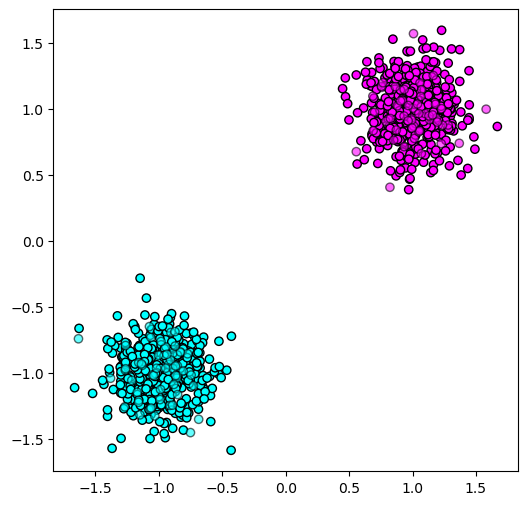

In [6]:
# Plot Data
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

X = np.array([s[0] for s in train_dataset.samples])
y = [s[1] for s in train_dataset.samples]
ax.scatter(X[:, 0], X[:, 1], c=y, cmap="cool", edgecolors="k")


X = np.array([s[0] for s in test_dataset.samples])
y = [s[1] for s in test_dataset.samples]
ax.scatter(X[:, 0], X[:, 1], c=y, cmap="cool", edgecolors="k", alpha=0.6)

plt.show()

In [7]:
accuracies = {"val": {}, "test": {}, "train": {}}
for lr, trainers_lr in trainers.items():
    print(f"LR {lr}...")
    accuracies["val"][lr] = {}
    accuracies["test"][lr] = {}
    accuracies["train"][lr] = {}
    for name, trainer_list in trainers_lr.items():
        print(name)

        accuracies["val"][lr][name] = []
        accuracies["test"][lr][name] = []
        accuracies["train"][lr][name] = []

        # if name == "lfp-zplus-zminus":
        #     retrain_models = True
        # else:
        #     retrain_models = False

        for t, trainer in enumerate(trainer_list):
            print(f"{weight_initializations[t]}: Trainer {t}")
            ckpt_path = os.path.join(savepath, f"ckpts-lr-{lr}")
            os.makedirs(ckpt_path, exist_ok=True)
            savename = f"{name}-model-{t}"
            saveappendage = "last"
            if retrain_models or not os.path.exists(os.path.join(ckpt_path, f"{savename}-{saveappendage}.pt")):
                # print(f"Training {t+1}-th trainer for propagator {name}...")
                trainer.train(
                    epochs=epochs,
                    verbose=True,
                    savepath=ckpt_path,
                    savename=savename,
                    saveappendage=saveappendage,
                    fromscratch=True,
                )
            else:
                # print(f"Loading checkpoint {os.path.join(ckpt_path, f'{savename}-{saveappendage}.pt')}")
                trainer.load(savepath=ckpt_path, savename=savename, saveappendage=saveappendage)
            eval_stats = trainer.eval(datamodes=["test", "val", "train"])
            # print(f'(Test Accuracy) {res["test"]["accuracy"]}')
            accuracies["val"][lr][name].append(
                eval_stats["val"]["accuracy_p050"]
                if "accuracy_p050" in eval_stats["val"].keys()
                else eval_stats["val"]["micro_accuracy_top1"]
            )
            accuracies["test"][lr][name].append(
                eval_stats["test"]["accuracy_p050"]
                if "accuracy_p050" in eval_stats["test"].keys()
                else eval_stats["test"]["micro_accuracy_top1"]
            )
            accuracies["train"][lr][name].append(
                eval_stats["train"]["accuracy_p050"]
                if "accuracy_p050" in eval_stats["train"].keys()
                else eval_stats["train"]["micro_accuracy_top1"]
            )

LR 0.5...
lfp-epsilon
(0.0, 4.0): Trainer 0
(4.0, 0.0): Trainer 1
(2.0, 4.0): Trainer 2
(4.0, 2.0): Trainer 3
(-4.0, -4.0): Trainer 4
(-4.0, 4.0): Trainer 5
(4.0, -4.0): Trainer 6
vanilla-gradient
(0.0, 4.0): Trainer 0
(4.0, 0.0): Trainer 1
(2.0, 4.0): Trainer 2
(4.0, 2.0): Trainer 3
(-4.0, -4.0): Trainer 4
(-4.0, 4.0): Trainer 5
(4.0, -4.0): Trainer 6


In [8]:
# Plot Settings
# Set font properties.
import matplotlib.font_manager as font_manager

font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams["axes.linewidth"] = 1.5

### Plot Val Accuracies Over LR

val
MAX: lfp-epsilon - 0.5
MAX: vanilla-gradient - 0.5


/tmp/ipykernel_255884/995124871.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


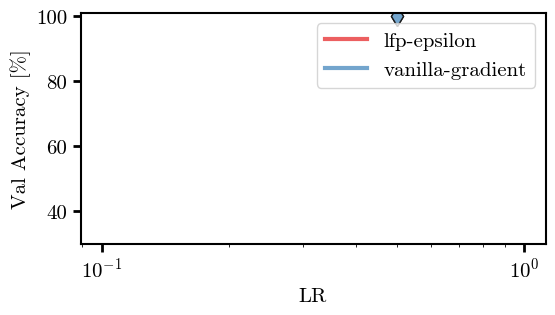

test
MAX: lfp-epsilon - 0.5
MAX: vanilla-gradient - 0.5


/tmp/ipykernel_255884/995124871.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


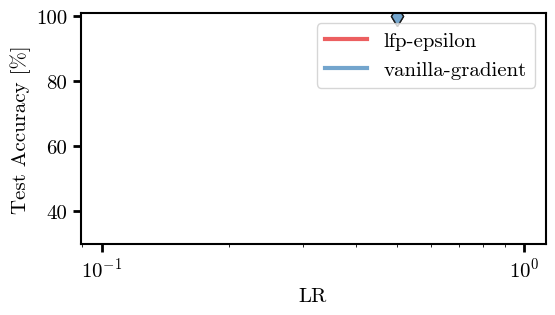

train
MAX: lfp-epsilon - 0.5
MAX: vanilla-gradient - 0.5


/tmp/ipykernel_255884/995124871.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


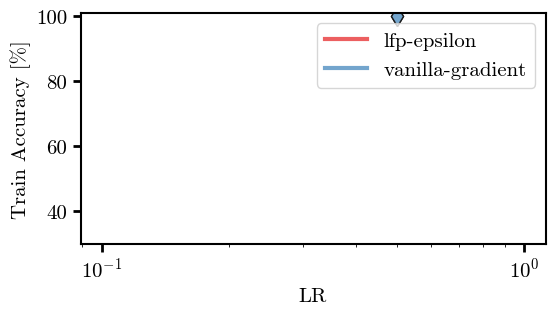

In [9]:
import matplotlib.cm as cm


def plot_accuracies(accuracy_res, name, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    lrs = np.sort([k for k in accuracy_res.keys()])
    methods = [m for m in accuracy_res[lrs[0]].keys()]

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))

    maxacclrs = []

    for m, method in enumerate(methods):
        plot_means = []
        plot_stds = []
        for lr in lrs:
            plot_means.append(np.mean(accuracy_res[lr][method]))
            plot_stds.append(np.std(accuracy_res[lr][method]))

        plot_means = np.array(plot_means)
        plot_stds = np.array(plot_stds)

        maxx = lrs[np.argmax(plot_means)]
        maxy = np.max(plot_means)
        print(f"MAX: {method} - {maxx}")
        maxacclrs.append((method, maxx, maxy))

        ax.plot(lrs, plot_means, color=palette[m], label=method, linewidth=3, alpha=1)
        ax.plot(
            maxx,
            maxy,
            color=palette[m],
            marker="d",
            markersize=10,
            markeredgecolor=(0.1, 0.1, 0.1, 1),
        )
        ax.fill_between(
            lrs,
            plot_means + plot_stds,
            plot_means - plot_stds,
            color=palette[m],
            alpha=0.2,
        )

    ax.legend()
    ax.set_xscale("log")

    if name == "test":
        nam = "Test"
    if name == "train":
        nam = "Train"
    if name == "val":
        nam = "Val"

    ax.set_ylabel(f"{nam} Accuracy [%]")
    ax.set_xlabel("LR")
    ax.set_ylim([0.3, 1.01])
    ax.set_yticks([0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    # ax.set_xlim([0, 10e-2])
    plt.show()
    fig.savefig(fname)

    return maxacclrs


maxacclrs = {}
for name, val in accuracies.items():
    print(name)
    fname = os.path.join(savepath, f"accuracy-{name}.svg")
    maxacclrs[name] = plot_accuracies(val, name, fname)

### Plot Train/Val Accuracies over steps for best performing models

lfp-epsilon 0.5 1.0


/tmp/ipykernel_255884/1917551070.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


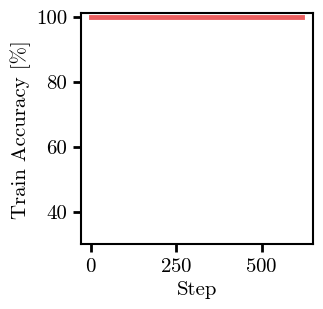

vanilla-gradient 0.5 1.0


/tmp/ipykernel_255884/1917551070.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


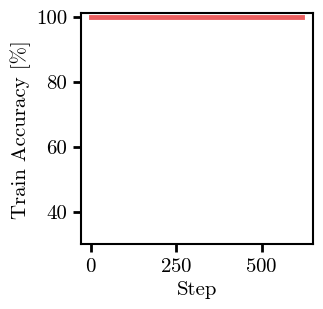

In [10]:
def plot_accuracies_over_epochs(accuracy_logs, fname, colormap="Set1"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    datasplit = [m for m in accuracy_logs[0].keys() if m == "train"]

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))

    for s, split in enumerate(datasplit):
        plot_data = [accuracy_logs[i][split] for i in range(len(accuracy_logs))]
        plot_means = np.mean(plot_data, axis=0)
        plot_stds = np.std(plot_data, axis=0)

        xaxis = np.arange(0, len(plot_means)) * 5

        ax.plot(xaxis, plot_means, color=palette[s], label=split, linewidth=3.5, alpha=1)
        ax.fill_between(
            xaxis,
            plot_means + plot_stds,
            plot_means - plot_stds,
            color=palette[s],
            alpha=0.2,
        )

    ax.set_ylabel("Train Accuracy [%]")
    ax.set_xlabel("Step")
    ax.set_ylim([0.3, 1.01])
    ax.set_yticks([0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    # ax.set_xlim([0, 100])
    # ax.legend()
    plt.show()
    fig.savefig(fname)


toplot = maxacclrs["test"]
for name, lr, acc in toplot:
    print(name, lr, acc)
    plot_accuracies_over_epochs(
        [trainers[lr][name][0].accuracy_log],
        fname=os.path.join(savepath, f"accuracy-lr-{lr}-{name}.svg"),
    )

### Plot Decision Boundaries

lfp-epsilon 0.5 1.0


/tmp/ipykernel_255884/716607234.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap, 256)
/tmp/ipykernel_255884/716607234.py:34: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:


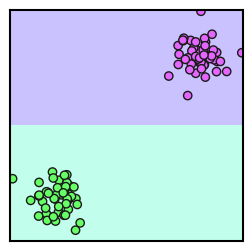

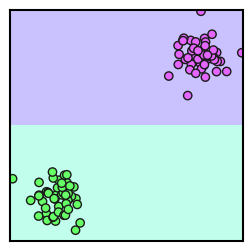

vanilla-gradient 0.5 1.0


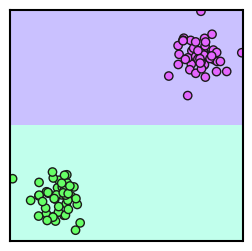

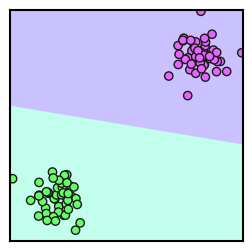

In [11]:
def plot_classifier_boundaries(
    model,
    dataset,
    xlim=(-1.67, 1.6),
    ylim=(-1.6, 1.6),
    colormap="gist_rainbow",
    fname="",
):
    xgrid = np.arange(xlim[0], xlim[1], 0.01)
    ygrid = np.arange(ylim[0], ylim[1], 0.01)

    xx, yy = np.meshgrid(xgrid, ygrid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1, r2))

    from matplotlib.colors import ListedColormap

    pastel = 0.4
    cmap = cm.get_cmap(colormap, 256)
    newcolors = [cmap(np.linspace(0.4, 0.92, 128))]
    newcolors = (1 - pastel) * np.repeat(newcolors, 2, axis=1)[0] + pastel * np.ones((256, 4))
    colormap = ListedColormap(newcolors.clip(max=1))

    edgecolor = np.ones(4) * 0.1

    # from matplotlib.colors import ListedColormap
    # colors = np.linspace(0, 1, 9)
    # palette = cm.get_cmap(colormap)(colors)
    # pastel = 0.0
    # palette = (1-pastel)*palette+pastel*np.ones((9, 4))
    # reduced_palette = np.array([palette[2], palette[8], palette[3]]) #green, grey, purple
    # colormap = ListedColormap(reduced_palette)

    yhat = torch.sigmoid(model(torch.from_numpy(grid).float().to(device))).detach().cpu().numpy()
    yhat_cl = yhat > 0.5

    zz = yhat_cl.reshape(xx.shape)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    cnt = ax.contourf(xx, yy, zz, cmap=colormap, alpha=0.4)
    for c in cnt.collections:
        c.set_edgecolor("face")
        c.set_linewidth(0.000000000001)

    samples = copy.deepcopy(dataset.samples)
    np.random.shuffle(samples)
    # samples = samples[:200]

    X = np.array([s[0] for s in samples])
    y = [s[1] for s in samples]
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=colormap, edgecolors=edgecolor, alpha=1, marker="o")

    ax.set_xticks([])
    ax.set_yticks([])
    # plt.axis("off")

    plt.show()

    fig.savefig(fname)


toplot = maxacclrs["test"]
# for lr in pl_lrs:
#     print("LR", lr)
#     for name, trainer_list in trainers[lr].items():
for name, lr, acc in toplot:
    print(name, lr, acc)
    plot_classifier_boundaries(
        init_models[0],
        test_dataset,
        fname=os.path.join(savepath, f"boundary-lr-{lr}-init-model_0.svg"),
    )
    plot_classifier_boundaries(
        trainers[lr][name][0].model,
        test_dataset,
        fname=os.path.join(savepath, f"boundary-lr-{lr}-name-{name}.svg"),
    )

### Weight Progression

/tmp/ipykernel_255884/3902947860.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap, 256)


lfp-epsilon 0.5 1.0


100%|██████████| 44944/44944 [06:22<00:00, 117.38it/s]
/tmp/ipykernel_255884/3902947860.py:166: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for cline in cnt.collections:
/tmp/ipykernel_255884/3902947860.py:181: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Oranges", 256)


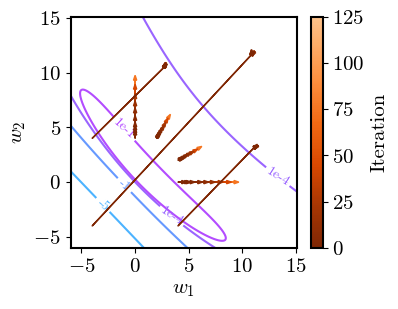

vanilla-gradient 0.5 1.0


100%|██████████| 44944/44944 [06:13<00:00, 120.36it/s]


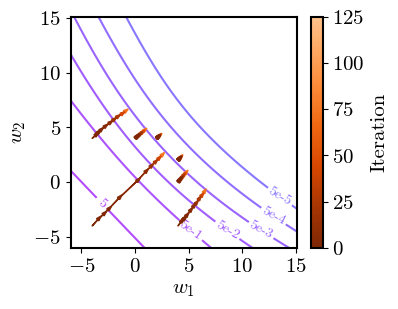

In [48]:
from matplotlib.collections import LineCollection


def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)


def plot_weightspace_progression(trainers, xlim=(-6, 15.2), ylim=(-6, 15.2), colormap="cool", fname=""):
    from matplotlib.colors import ListedColormap

    pastel = 0.0
    cmap = cm.get_cmap(colormap, 256)
    newcolors = [cmap(np.linspace(0.3, 0.7, 128))]
    newcolors = (1 - pastel) * np.repeat(newcolors, 2, axis=1)[0] + pastel * np.ones((256, 4))

    ct = copy.deepcopy(trainers[0])
    colormap = ListedColormap(newcolors.clip(max=1))

    # if ct.lfp_composite == None:
    #    colormap = ListedColormap(newcolors.clip(max=1)[::-1])
    # else:
    #    colormap = ListedColormap(newcolors.clip(max=1))

    np.ones(4) * 0.1

    xgrid = np.arange(xlim[0], xlim[1], 0.1)
    ygrid = np.arange(ylim[0], ylim[1], 0.1)

    xx, yy = np.meshgrid(xgrid, ygrid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1, r2))

    crits = []
    optimum = np.inf if ct.lfp_composite is None else -np.inf
    with tqdm(total=len(grid), disable=False) as pbar:
        for g in grid:
            for p in ct.model.parameters():
                p.data.view(-1)[0] = g[0]
                p.data.view(-1)[1] = g[1]
            eval_stats = ct.eval(datamodes=["test"])
            crit = eval_stats["test"]["criterion"]  # if ct.lfp_composite == None else eval_stats["test"]["criterion"]
            crits.append(crit)
            pbar.update(1)

            if ct.lfp_composite is None:
                if crit <= optimum:
                    optimum = crit
            else:
                if crit >= optimum:
                    optimum = crit

            # print(g, crit)
    zz = np.array(crits).reshape(xx.shape)

    if ct.lfp_composite is None:
        contour_levels = [0.00005, 0.0005, 0.005, 0.05, 0.5, 5.0]
    else:
        contour_levels = [-5.0, -1.0, 0.0001, 0.1]  # [-5.0, -1.0, 0.001, 0.1]

    neg_border = 0.5 - 0.5 / sum(np.array(contour_levels) < 0.0) if sum(np.array(contour_levels) < 0.0) > 0 else 0.5
    pos_border = 0.5 + 0.5 / sum(np.array(contour_levels) > 0.0) if sum(np.array(contour_levels) > 0.0) > 0 else 0.5
    cidx = np.concatenate(
        [
            np.linspace(0, neg_border, sum(np.array(contour_levels) < 0.0)),
            np.linspace(0.5, 0.5, sum(np.array(contour_levels) == 0.0)),
            np.linspace(pos_border, 1.0, sum(np.array(contour_levels) > 0.0)),
        ]
    )

    # Draw Contour
    fig, ax = plt.subplots(1, 1, figsize=(3.65, 3))
    cnt = ax.contour(
        xx,
        yy,
        zz,
        alpha=1.0,
        levels=contour_levels,
        vmin=np.min(contour_levels),
        vmax=np.max(contour_levels),
        colors=colormap(cidx),
    )

    def formatter(x):
        return str(int(x)) if x.is_integer() else np.format_float_scientific(x, precision=None, exp_digits=1, trim="-")

    cls = ax.clabel(cnt, cnt.levels, inline=True, fontsize=10, fmt=formatter)

    # Ensure labels are withing borders
    thresh = 0.075
    xmin, xmax, ymin, ymax = plt.axis()
    Dx = xmax - xmin
    Dy = ymax - ymin
    keep_labels = []

    for l, label in enumerate(cls):
        lx, ly = label.get_position()
        if xmin + thresh * Dx < lx < xmax - thresh * Dx and ymin + thresh * Dy < ly < ymax - thresh * Dy:
            keep_labels.append((lx, ly))
        else:
            # print(xmin, xmax, ymin, ymax)
            # print(xmin+thresh*Dx, xmax-thresh*Dx, ymin+thresh*Dy, ymax-thresh*Dy)
            # if lx >= xmax-thresh*Dx:
            #     lx -= lx-(xmax-thresh*Dx)
            #     ly += lx-(xmax-thresh*Dx)
            # elif lx <= xmin+thresh*Dx:
            #     lx += (xmin+thresh*Dx)-lx
            #     ly -= lx-(xmax-thresh*Dx)
            # if ly >= ymax-thresh*Dy:
            #     lx += ly-(ymax-thresh*Dy)
            #     ly -= ly-(ymax-thresh*Dy)
            # elif ly <= ymin+thresh*Dy:
            #     lx -= (ymin+thresh*Dy)-ly
            #     ly += (ymin+thresh*Dy)-ly

            idx = 0
            while not (xmin + thresh * Dx < lx < xmax - thresh * Dx and ymin + thresh * Dy < ly < ymax - thresh * Dy):
                line = np.concatenate(cnt.allsegs[l], axis=0)
                # idx = np.random.choice(np.arange(len(line)))
                # print(line)
                # print(line[idx])
                lx, ly = line[idx]
                idx += 1

            keep_labels.append((lx, ly))

    # print([(label.get_text(), label.get_position()) for label in cls])
    # print(keep_labels)
    for cline in cnt.collections:
        cline.remove()
    for label in cls:
        label.remove()

    cnt = ax.contour(
        xx,
        yy,
        zz,
        alpha=1.0,
        levels=contour_levels,
        vmin=np.min(contour_levels),
        vmax=np.max(contour_levels),
        colors=colormap(cidx),
    )
    cls = ax.clabel(cnt, cnt.levels, inline=True, fontsize=10, fmt=formatter, manual=keep_labels)

    # Draw training progress
    for trainer in trainers:
        toplot = np.array(trainer.param_log)
        toplot_idx = np.concatenate(
            [
                np.array([0]),
                np.ceil(np.logspace(0, np.log10(len(toplot) - 1), 10)).astype(int),
            ]
        )
        toplot = toplot[toplot_idx]
        np.linspace(0, 2, len(toplot))

        cmap = cm.get_cmap("Oranges", 256)
        newcolors = cmap(np.linspace(0.3, 1.0, 256))
        pastel = 0.0
        newcolors = (1 - pastel) * newcolors + pastel * np.ones((256, 4))
        trainer_cm = ListedColormap(newcolors.clip(max=1)[::-1])

        sc = ax.scatter(toplot[:, 0], toplot[:, 1], c=toplot_idx, marker="", cmap=trainer_cm)
        arrowcolors = trainer_cm(toplot_idx / np.max(toplot_idx))
        # print(arrowcolors)
        for i, xy in enumerate(toplot[:-1]):
            ax.arrow(
                xy[0],
                xy[1],
                toplot[i + 1][0] - xy[0],
                toplot[i + 1][1] - xy[1],
                color=arrowcolors[i],
                width=0.03,
                head_width=0.3,
                head_starts_at_zero=False,
                zorder=100 - i,
            )
        # colored_line(toplot[:, 0], toplot[:, 1], color, ax, linewidth=1, cmap="winter")

    # Draw Optimum
    # ax.plot(opt_weight[0], opt_weight[1], marker="x", color="red", linewidth=0)

    # ax.set_xticks([])
    # ax.set_yticks([])
    # plt.axis("off")
    cbar = plt.colorbar(sc)
    cbar.set_label("Iteration")
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    ax.set_xticks([-5, 0, 5, 10, 15])
    ax.set_yticks([-5, 0, 5, 10, 15])

    plt.show()

    fig.savefig(fname)


toplot = maxacclrs["test"]
# for lr in pl_lrs:
#     print("LR", lr)
#     for name, trainer_list in trainers[lr].items():
for name, lr, acc in toplot:
    # if name == "vanilla-gradient":
    print(name, lr, acc)
    # plot_weightspace_progression([trainers[lr][name][0], trainers[lr][name][2], trainers[lr][name][4]], fname = os.path.join(savepath, f"weightspace-lr-{lr}-name-{name}.svg"))
    plot_weightspace_progression(
        trainers[lr][name],
        fname=os.path.join(savepath, f"weightspace-lr-{lr}-name-{name}.svg"),
    )
    # plot_weightspace_progression([trainers[lr][name][1]], fname = os.path.join(savepath, f"weightspace-lr-{lr}-name-{name}.svg"))
    # plot_weightspace_progression([trainers[lr][name][2]], fname = os.path.join(savepath, f"weightspace-lr-{lr}-name-{name}.svg"))
    # plot_weightspace_progression([trainers[lr][name][3]], fname = os.path.join(savepath, f"weightspace-lr-{lr}-name-{name}.svg"))